In [1]:
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, ReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split

ModuleNotFoundError: No module named 'tensorflow'

# 1. First we use the provided code snippets to load the data

In [2]:
#to load all datasets
data = []
for i in range(30):
    data.append(np.load('exam_'+str(i)+'.npy'))
data=np.array(data)
np.shape(data)



(30, 1001, 40, 40)

In [3]:
# Calculates the energy of each state in the dataset
def energy(data):
    configuration = data
    gridsize = np.size(data,1)
    energy = np.zeros(np.size(data,0))
    for i in range(gridsize):
        for j in range(gridsize):
            spin = configuration[:,i,j]
            nearest_neighbors = configuration[:,(i+1)%gridsize, j] + configuration[:,i,(j+1)%gridsize] + configuration[:,(i-1)%gridsize, j] + configuration[:,i,(j-1)%gridsize]
            energy += -nearest_neighbors*spin
    return energy/2.

# Calculates the magnetization of each state in the dataset 
def magnetization(data):
    configuration = data
    magnetization = np.sum(np.sum(configuration,axis=2),axis=1)
    return magnetization

#We want to train the GAN fron one temperature below criticaliy and one above. We randomly chose the datasets 4 (high temp) and 16 (low temp)

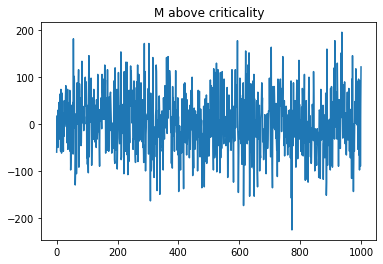

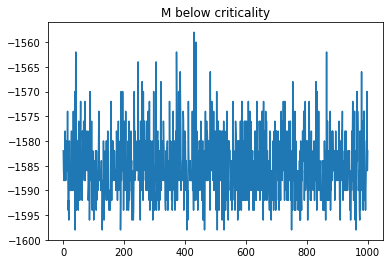

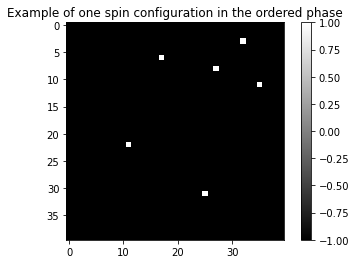

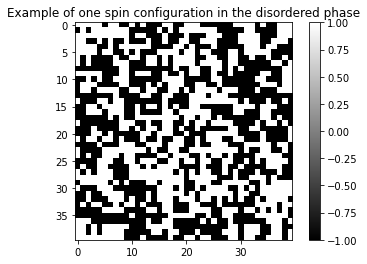

In [13]:
low_temp_data = data[16]
high_temp_data = data[4]


plt.plot(magnetization(high_temp_data))
plt.title('M above criticality')
plt.show()
plt.plot(magnetization(low_temp_data))
plt.title('M below criticality')
plt.show()
plt.imshow(low_temp_data[8].reshape(40,40), cmap='gray')
plt.title('Example of one spin configuration in the ordered phase')
plt.colorbar()
plt.show()
plt.imshow(high_temp_data[8].reshape(40,40), cmap='gray')
plt.title('Example of one spin configuration in the disordered phase')
plt.colorbar()
plt.show()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_135 (Conv2D)          (None, 20, 20, 16)        160       
_________________________________________________________________
leaky_re_lu_108 (LeakyReLU)  (None, 20, 20, 16)        0         
_________________________________________________________________
dropout_108 (Dropout)        (None, 20, 20, 16)        0         
_________________________________________________________________
conv2d_136 (Conv2D)          (None, 10, 10, 32)        4640      
_________________________________________________________________
zero_padding2d_27 (ZeroPaddi (None, 11, 11, 32)        0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 11, 11, 32)        128       
_________________________________________________________________
leaky_re_lu_109 (LeakyReLU)  (None, 11, 11, 32)      

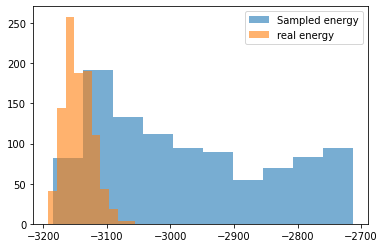

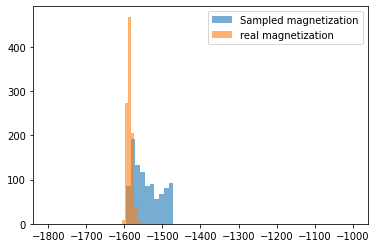

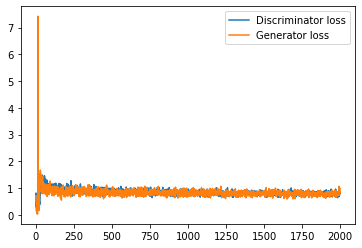

In [41]:
#Change this to high_temp_data for the disordered phase
dataset = low_temp_data

class DCGAN():
    def __init__(self):
        #Here we define the input shapes of the generator and the discriminator
        self.rows = 40
        self.cols = 40
        self.color_channels = 1
        self.img_shape = (self.rows, self.cols, self.color_channels)

        #We chose a latent space dimension of (2,1)
        self.latent_dim = 2

        #Selection of the hyperparameters for our optimizer
        optimizer = Adam(0.0002, 0.1)    


        #Calling our discriminator and generator functions
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        self.generator = self.build_generator()
        
        #z is a placeholder for future data
        z = Input(shape=(self.latent_dim,))
        #Now we generate an image and pass it on to the discriminator who tries to find out if its real
        img = self.generator(z)

        #Since we only want to adjust the generator weights while training the combined model we set trainability = false
        self.discriminator.trainable = False
        valid = self.discriminator(img)

       #Now we combine the generator and the discriminator in order to train them in competition to each other
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    
    #A transposed CNN converts our latent space input into an Ising-Sample
    def build_generator(self):

        model = Sequential()
        model.add(Dense(128 * 10 * 10, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((10, 10, 128)))
        model.add(Conv2DTranspose(128, kernel_size=4, strides = 2, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2DTranspose(64, kernel_size=4, strides = 2, padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(1, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
        

    #Same for the discriminator. Here a (40,40) input gets processed through a CNN to a scalar output of 0/1
    def build_discriminator(self):

        model = Sequential()
        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    #Now we start the training process with 1001 Ising samples from either above or below the critical temp
    def train(self, epochs, batch_size=128, save_interval=50):    
        X_train = dataset
        
        #These are the labels we use in the loss function
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        
        #We want to plot our losses
        Disc_loss = []
        Gen_loss = []


        for epoch in range(epochs):
            #Now we take a batch consisting of half real half fake images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            #The Discriminator has to decide which ones are real and which fake
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            #Showing the learning process
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            Disc_loss.append(d_loss[0])
            Gen_loss.append(g_loss)
            #We save a picture every few steps
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

            #We plot the distribution of magnetization and energy at the end of our epochs
            if epoch == (epochs-1):
              print(epoch)
              #generating a few samples with our generator and compare them to real data
              noise = np.random.normal(0, 1, (1001, self.latent_dim))
              samples = self.generator.predict(noise)
              real_energy = energy(dataset)
              sample_energy = energy(samples[:,:,:,0])
              plt.hist(sample_energy, label = 'Sampled energy', alpha = 0.6)
              plt.hist(real_energy, label = 'real energy', alpha = 0.6)
              plt.legend()
              plt.show()
              sample_magnetization = magnetization(samples)
              real_magnetization = magnetization(dataset)
              plt.hist(sample_magnetization, label = 'Sampled magnetization', alpha = 0.6)
              plt.hist(real_magnetization, label = 'real magnetization', bins = np.linspace(-1800,-1000, 100), alpha = 0.6)
              plt.legend()
              plt.show()
              plt.plot(Disc_loss, label = 'Discriminator loss')
              plt.plot(Gen_loss, label = 'Generator loss')
              plt.legend()
              plt.show()

    #function to save plots
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("poly_%d.png" % epoch)
        plt.close()

        


if __name__ == '__main__':
    dcgan = DCGAN()
dcgan.train(epochs=2000, batch_size=16, save_interval=50)




In [42]:
dcgan.generator.save('Generator_Model')
dcgan.discriminator.save('Discriminator_Model')
dcgan.combined.save('Combined_Model')

INFO:tensorflow:Assets written to: Generator_Model/assets
INFO:tensorflow:Assets written to: Discriminator_Model/assets
INFO:tensorflow:Assets written to: Combined_Model/assets


##Now we implement a similar GAN but with a different loss. The Wasserstein loss can be calculated by comparing the distance of the estimated and the sample distribution. We can use the previous GAN for some parts but adjustments need to be made with the loss function, the discriminator weights and the discriminator outputs

Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_140 (Conv2D)          (None, 20, 20, 128)       1280      
_________________________________________________________________
leaky_re_lu_112 (LeakyReLU)  (None, 20, 20, 128)       0         
_________________________________________________________________
dropout_112 (Dropout)        (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_141 (Conv2D)          (None, 10, 10, 256)       295168    
_________________________________________________________________
zero_padding2d_28 (ZeroPaddi (None, 11, 11, 256)       0         
_________________________________________________________________
batch_normalization_118 (Bat (None, 11, 11, 256)       1024      
_________________________________________________________________
leaky_re_lu_113 (LeakyReLU)  (None, 11, 11, 256)     

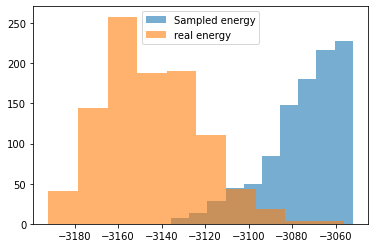

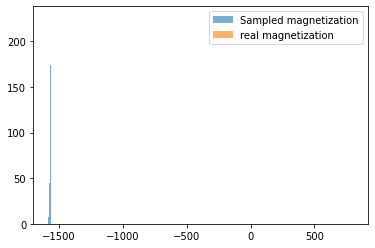

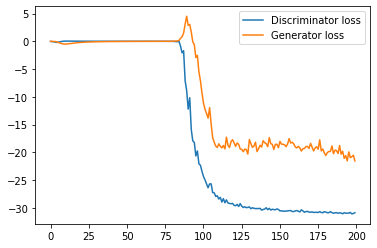

In [43]:
dataset = low_temp_data


class WGAN():
    def __init__(self):
        #Here we define the input shapes of the generator and the discriminator
        self.rows = 40
        self.cols = 40
        self.color_channels = 1
        self.img_shape = (self.rows, self.cols, self.color_channels)

        #We chose a latent space dimension of (2,1)
        self.latent_dim = 2

        #Selection of the hyperparameters for our optimizer
        optimizer = Adam(0.0002, 0.1)    
        #optimizer = RMSprop(lr=0.00003)

        #Also we have to define a clipping value for the discriminator weights
        self.n_critic = 10
        self.clip_value = 0.03


        #Calling our discriminator and generator functions
        self.Wdiscriminator = self.build_Wdiscriminator()
        self.Wdiscriminator.compile(loss=self.wasserstein_loss, optimizer=optimizer, metrics=['accuracy'])
        self.generator = self.build_generator()
        
        #z is a placeholder for future data
        z = Input(shape=(self.latent_dim,))
        #Now we generate an image and pass it on to the discriminator who tries to find out if its real
        img = self.generator(z)
        self.Wdiscriminator.trainable = False
        valid = self.Wdiscriminator(img)

       #Now we combine the generator and the discriminator in order to train them in competition to each other
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss, optimizer=optimizer)
    
    #The new loss function compares the horizontal distance between the original and the approximated distribution
    def wasserstein_loss(self, y_true, y_pred):
        return tf.keras.backend.mean(y_true * y_pred)

    #We use the same generator as with our normal GAN
    def build_generator(self):

        model = Sequential()
        model.add(Dense(128 * 10 * 10, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((10, 10, 128)))
        model.add(Conv2DTranspose(128, kernel_size=4, strides = 2, padding="same"))
        model.add(Activation("relu"))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2DTranspose(64, kernel_size=4, strides = 2, padding="same"))
        model.add(Activation("relu"))
        #model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(1, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)

    #for the discriminator we follow the architecture outlined in the lecture
    def build_Wdiscriminator(self):

        model = Sequential()
        x=8
        model.add(Conv2D(x*16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(x*32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(x*64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(x*128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):
        X_train = dataset

        #This time we have to label fake images as -1 because we use the Wasserstein distance as a loss 
        valid = np.ones((batch_size, 1))
        fake = -np.ones((batch_size, 1))
        #We want to plot our losses
        Disc_loss = []
        Gen_loss = []


        for epoch in range(epochs):

            self.Wdiscriminator.trainable = True
            for _ in range(self.n_critic):
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                d_loss_real = self.Wdiscriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.Wdiscriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip weights that are bigger than a critical value. This is essential for the WGAN
                for l in self.Wdiscriminator.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            self.Wdiscriminator.trainable = False
            g_loss = self.combined.train_on_batch(noise, valid)

            #Print progress and stack losses for each epoch
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss))
            Disc_loss.append(d_loss[0])
            Gen_loss.append(g_loss)


            #Saving images
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

            #We plot the distribution of magnetization and energy at the end of our epochs
            if epoch == (epochs-1):
              print(epoch)
              #generating a few samples with our generator and compare them to real data
              noise = np.random.normal(0, 1, (1001, self.latent_dim))
              samples = self.generator.predict(noise)
              print(np.shape(samples))
              real_energy = energy(dataset)
              print(np.shape(dataset))
              sample_energy = energy(samples[:,:,:,0])
              plt.hist(sample_energy, label = 'Sampled energy', alpha = 0.6)
              plt.hist(real_energy, label = 'real energy', alpha = 0.6)
              plt.legend()
              plt.show()
              sample_magnetization = magnetization(samples)
              real_magnetization = magnetization(dataset)
              plt.hist(sample_magnetization, label = 'Sampled magnetization', alpha = 0.6)
              plt.hist(real_magnetization, label = 'real magnetization', bins = np.linspace(-800,800, 100), alpha = 0.6)
              plt.legend()
              plt.show()
              plt.plot(Disc_loss, label = 'Discriminator loss')
              plt.plot(Gen_loss, label = 'Generator loss')
              plt.legend()
              plt.show()

    #saving the images
    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("W_poly_%d.png" % epoch)
        plt.close()


if __name__ == '__main__':
    wgan = WGAN()
wgan.train(epochs=200, batch_size=16, sample_interval=50)

In [35]:
wgan.generator.save('Generator_Model_W')
wgan.Wdiscriminator.save('Discriminator_Model_W')
wgan.combined.save('Combined_Model_W')

INFO:tensorflow:Assets written to: Generator_Model_W/assets
INFO:tensorflow:Assets written to: Discriminator_Model_W/assets
INFO:tensorflow:Assets written to: Combined_Model_W/assets
